<a href="https://colab.research.google.com/github/hydrationn/Machine-DeepLearning/blob/main/DeepLearning/assignment/%EA%B3%BC%EC%A0%9C6_2_Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Variational Autoencoder(VAE)

In [2]:
# Import package

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# GPU/CPU setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

cuda


In [4]:
# Import dataset

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16876136.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 439042.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3595334.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 922097.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Batch generation

batch_size = 256

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Model

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 인코더 부분
        self.fc1 = nn.Linear(784, 512)
        self.mu = nn.Linear(512, 50)
        self.logvar = nn.Linear(512, 50)
        # 디코더 부분
        self.fc2 = nn.Linear(50, 512)
        self.fc3 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.mu(h1)
        logvar = self.logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
model = VAE().to(device)

In [8]:
# Parameter, loss function, optimizer

def loss_function(recon_x, x, mu, logvar):
  Bernouhlli_loss = F.binary_cross_entropy(recon_x, x.reshape(-1, 784), reduction='sum')
  KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return Bernouhlli_loss + KL_divergence

In [9]:
# Hyperparameters

num_epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Model train

loss_list = []

for epoch_num in range(num_epochs):
  average_cost = 0

  for batch_idx, (images, label) in enumerate(train_loader):
    num_of_mini_batch = len(train_loader)

    images = images.to(device)
    input_image = images.reshape(-1, 28*28)
    optimizer.zero_grad()
    recon_x, mu, logvar = model(input_image)
    loss = loss_function(recon_x, input_image, mu, logvar)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 47660.270487
Epoch 2 Loss 34461.878221
Epoch 3 Loss 31286.959479
Epoch 4 Loss 29792.572295
Epoch 5 Loss 28935.882484
Epoch 6 Loss 28392.231861
Epoch 7 Loss 28015.745994
Epoch 8 Loss 27721.633523
Epoch 9 Loss 27503.353191
Epoch 10 Loss 27323.086843


In [11]:
# Test

for batch_size, (image, label) in enumerate(test_loader):
  with torch.no_grad():
    test_img = image.to(device)
    test_img = test_img.reshape(-1, 28*28)
    test_recon_x, _, _ = model(test_img)

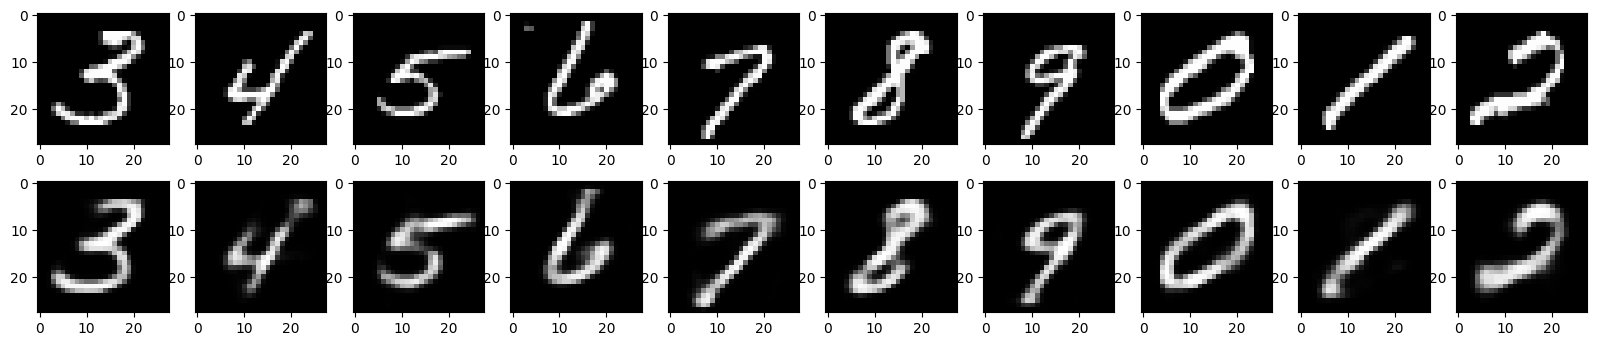

In [12]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
  ax = plt.subplot(2, 10, i+1)
  image = test_img[i].reshape(28, 28)
  plt.imshow(image.cpu(), cmap='gray')

  ax = plt.subplot(2, 10, i+1+n)
  recon_image = test_recon_x.data[i].cpu().reshape(28, 28)
  plt.imshow(recon_image, cmap='gray')